## Analysis of EyeT4 Data for Empathy Prediction



In [51]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
import numpy as np

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Loading Data for Test Group

In [3]:
data_dir = 'C:/Users/sayanDocuments/EyeT'
dataset_iii_files = [f for f in os.listdir(data_dir) if 'dataset_III' in f]

dfs = []
for file in dataset_iii_files:
    df = pd.read_csv(os.path.join(data_dir, file))
    dfs.append(df)
dataset_iii_combined = pd.concat(dfs)

In [87]:
dataset_iii_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3776742 entries, 0 to 8422
Data columns (total 71 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   Unnamed: 0                           int64  
 1   Recording timestamp                  int64  
 2   Computer timestamp                   int64  
 3   Sensor                               object 
 4   Project name                         object 
 5   Export date                          object 
 6   Participant name                     object 
 7   Recording name                       object 
 8   Recording date                       object 
 9   Recording date UTC                   object 
 10  Recording start time                 object 
 11  Recording start time UTC             object 
 12  Recording duration                   int64  
 13  Timeline name                        object 
 14  Recording Fixation filter name       object 
 15  Recording software version         

### Counting the number of Unique start time for each participant


In [4]:
participant_counts = dataset_iii_combined.groupby('Participant name')['Recording start time UTC'].nunique()

In [5]:
participant_counts

Participant name
Participant0001    8
Participant0003    8
Participant0005    8
Participant0007    8
Participant0009    8
Participant0011    8
Participant0013    8
Participant0015    8
Participant0017    8
Participant0019    8
Participant0021    8
Participant0023    8
Participant0025    8
Participant0027    8
Participant0029    8
Participant0031    8
Participant0033    8
Participant0035    8
Participant0037    8
Participant0039    8
Participant0041    8
Participant0043    8
Participant0045    8
Participant0047    8
Participant0049    8
Participant0051    8
Participant0053    8
Participant0055    8
Participant0057    8
Participant0059    8
Name: Recording start time UTC, dtype: int64

In [6]:
#Keeping only 3 classes for the eye movement type. Replacing the EyesNotFound as Unclassified
dataset_iii_combined = dataset_iii_combined.replace("EyesNotFound", "Unclassified")
dataset_iii_combined['Eye movement type'].fillna("Unclassified", inplace=True)

In [70]:
dataset_iii_combined['Eye movement type'].value_counts()

Fixation        1957041
Unclassified    1055207
Saccade          764494
Name: Eye movement type, dtype: int64

### Extracting only the important Features

In [8]:
final_df = dataset_iii_combined[["Participant name", "Recording timestamp", "Eye movement type", "Event", "Pupil diameter left",
                                     "Pupil diameter right"]]

In [9]:
#Converting the Pupil diameter left and right to float

final_df["Pupil diameter left"] = final_df["Pupil diameter left"].str.replace(',', '.').astype(float)
final_df["Pupil diameter right"] = final_df["Pupil diameter right"].str.replace(',', '.').astype(float)

In [10]:
#Function to fill the left pupil diameneter based on right
def fill_left_based_on_right(left, right):
    if np.isnan(left) and ~np.isnan(right): return right
    return left

In [11]:
#Function to fill the rigth pupil diameneter based on left 

def fill_right_based_on_left(left, right):
    if np.isnan(right) and ~np.isnan(left): return left
    return right

In [12]:
final_df["Pupil diameter left"] = final_df.apply(lambda x: fill_left_based_on_right(x['Pupil diameter left'],
                                                                                                   x['Pupil diameter right']), axis = 1 )
final_df["Pupil diameter right"] = final_df.apply(lambda x: fill_right_based_on_left(x['Pupil diameter left'],
                                                                                                    x['Pupil diameter right']), axis = 1)

In [13]:
final_df["Pupil diameter left"]

0        NaN
1        NaN
2        NaN
3        NaN
4       3.21
        ... 
8418    3.30
8419     NaN
8420     NaN
8421     NaN
8422     NaN
Name: Pupil diameter left, Length: 3776742, dtype: float64

### Calculating the mean Pupil Diameter

In [14]:
final_df["Pupil_diameter_mean"] = (final_df['Pupil diameter left'] + final_df['Pupil diameter right'])/2

In [86]:
final_df["Pupil_diameter_mean"]

0         NaN
1         NaN
2         NaN
3         NaN
4       3.175
        ...  
8418    3.260
8419      NaN
8420      NaN
8421      NaN
8422      NaN
Name: Pupil_diameter_mean, Length: 3776742, dtype: float64

In [16]:
df = final_df

In [17]:
df

,Participant name,Recording timestamp,Eye movement type,Event,Pupil diameter left,Pupil diameter right,Pupil_diameter_mean
0,Participant0001,23419315,Fixation,Eye tracker Calibration end,NaN,NaN,NaN
1,Participant0001,23419315,Fixation,ImageStimulusStart,NaN,NaN,NaN
2,Participant0001,23426120,Fixation,NaN,NaN,NaN,NaN
3,Participant0001,23434449,Fixation,NaN,NaN,NaN,NaN
4,Participant0001,23442782,Fixation,NaN,3.21,3.14,3.175
...,...,...,...,...,...,...,...
8418,Participant0003,74188757,Saccade,NaN,3.30,3.22,3.260
8419,Participant0003,74197135,Saccade,NaN,NaN,NaN,NaN
8420,Participant0003,74205245,Unclassified,MouseEvent,NaN,NaN,NaN
8421,Participant0003,74205245,Unclassified,NaN,NaN,NaN,NaN


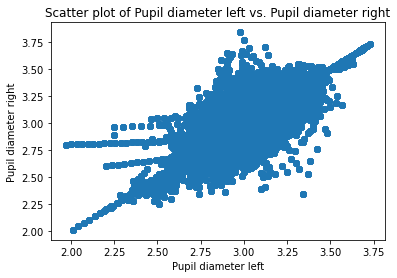

In [18]:
#Scatter plot to plot the Pupil Diameter left vs Pupil Diameter right for participant 1

participant_data = df[df['Participant name'] == 'Participant0001']
participant_data['Pupil diameter left'] = participant_data['Pupil diameter left'].interpolate()
participant_data['Pupil diameter right'] = participant_data['Pupil diameter right'].interpolate()

# Create a scatter plot of the 'Pupil diameter left' and 'Pupil diameter right' columns for all participants
plt.scatter(participant_data['Pupil diameter left'], participant_data['Pupil diameter right'])
plt.xlabel('Pupil diameter left')
plt.ylabel('Pupil diameter right')
plt.title('Scatter plot of Pupil diameter left vs. Pupil diameter right')
plt.show()

<Figure size 720x576 with 0 Axes>

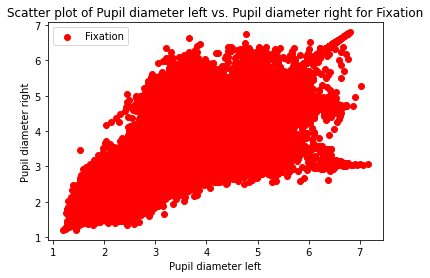

<Figure size 720x576 with 0 Axes>

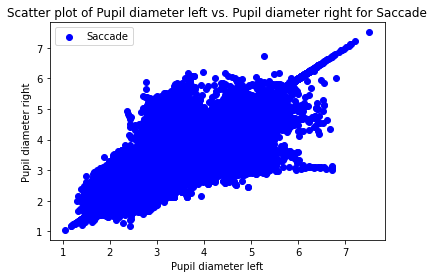

<Figure size 720x576 with 0 Axes>

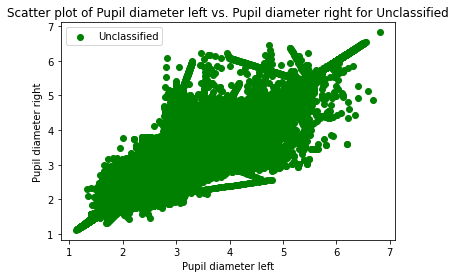

In [19]:

# Group the data by 'Eye movement type'
grouped_data = df.groupby('Eye movement type')

# Define a color map for each eye movement type
colors = {'Fixation': 'red', 'Saccade': 'blue', 'Unclassified': 'green'}

# Create a scatter plot of the 'Pupil diameter left' and 'Pupil diameter right' columns for each eye movement type
for key, group in grouped_data:
    plt.figure(figsize = (10,8))
    fig, ax = plt.subplots()
    participant_data = group
    participant_data['Pupil diameter left'] = participant_data['Pupil diameter left'].interpolate()
    participant_data['Pupil diameter right'] = participant_data['Pupil diameter right'].interpolate()
    ax.scatter(participant_data['Pupil diameter left'], participant_data['Pupil diameter right'], c=colors[key], label=key)
    ax.set_xlabel('Pupil diameter left')
    ax.set_ylabel('Pupil diameter right')
    ax.set_title('Scatter plot of Pupil diameter left vs. Pupil diameter right for {}'.format(key))
    ax.legend()
    plt.show()

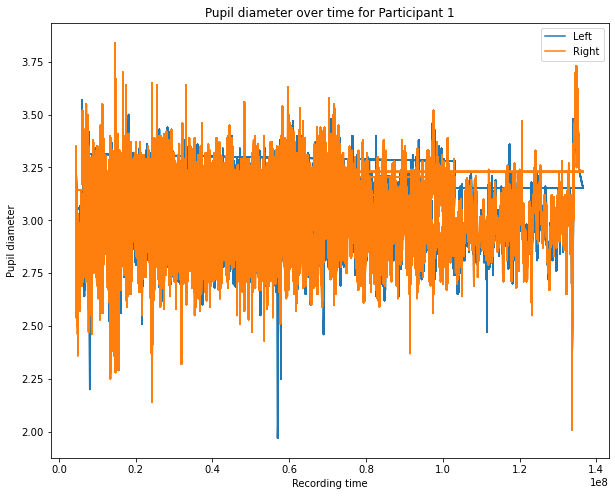

In [20]:

#Pupil diameter over timestamp for participant 1

participant_data = df[df['Participant name'] == 'Participant0001']

# Fill missing values using linear interpolation
participant_data['Pupil diameter left'] = participant_data['Pupil diameter left'].interpolate()
participant_data['Pupil diameter right'] = participant_data['Pupil diameter right'].interpolate()

# Creating a line plot of the 'Pupil diameter left' and 'Pupil diameter right' columns over time
plt.figure(figsize = (10,8))
plt.plot(participant_data['Recording timestamp'], participant_data['Pupil diameter left'], label='Left')
plt.plot(participant_data['Recording timestamp'], participant_data['Pupil diameter right'], label='Right')
plt.xlabel('Recording time')
plt.ylabel('Pupil diameter')
plt.title('Pupil diameter over time for Participant 1')
plt.legend()
plt.show()

### Creating time series for participant( 1 time series each trial)

In [21]:
results = pd.DataFrame(columns=['Participant', 'Time Series', 'Mean Pupil Diameter', 'Fixation Fraction', 'Saccade Fraction', 'Fixation Count', 'Saccade Count', 'Fixation Duration', 'Saccade Duration'])

# Group the eye movement data by participant
grouped_data = df.groupby('Participant name')

# Loop over each participant and extract data for each time series
for name, group in grouped_data:

    # Finding the start and end timestamps for the image stimulus presentation 
    start_timestamp = group.loc[group['Event'] == 'ImageStimulusStart', 'Recording timestamp'].values[0]
    end_timestamp = group.loc[group['Event'] == 'ImageStimulusEnd', 'Recording timestamp'].values[0]

    # Calculating the total duration of the image stimulus presentation
    total_duration = end_timestamp - start_timestamp

    # Calculate the duration of each time series
    series_duration = total_duration / 8

    # Loop over each time series and extract the eye movement data
    for i in range(8):
        # Calculate the start and end timestamps for this time series
        series_start = start_timestamp + i * series_duration
        series_end = start_timestamp + (i+1) * series_duration

        # Filter the eye movement data for this time series
        series_data = group[(group['Recording timestamp'] >= series_start) & (group['Recording timestamp'] < series_end)]

        # Calculate the mean pupil diameter for this time series
        mean_pupil_diameter = series_data['Pupil_diameter_mean'].mean()
        mean_pupil_diameter_left = series_data['Pupil diameter left'].mean()
        mean_pupil_diameter_right = series_data['Pupil diameter right'].mean()

        # Calculate the fixation and saccade fractions for this time series
        total_events = len(series_data)
        fixation_events = len(series_data[series_data['Eye movement type'] == 'Fixation'])
        saccade_events = len(series_data[series_data['Eye movement type'] == 'Saccade'])

        fixation_frac = fixation_events / total_events
        saccade_frac = saccade_events / total_events

        # Calculate the fixation and saccade durations for this time series
        fixation_duration = series_data[series_data['Eye movement type'] == 'Fixation']['Recording timestamp'].diff().sum()
        saccade_duration = series_data[series_data['Eye movement type'] == 'Saccade']['Recording timestamp'].diff().sum()

        # Append the results for this time series as a new row to the DataFrame
        results = results.append({'Participant': name, 'Time Series': i+1,
                                  'Mean Pupil Diameter left': mean_pupil_diameter_left,
                                  'Mean Pupil Diameter right': mean_pupil_diameter_right,
                                  'Mean Pupil Diameter': mean_pupil_diameter, 
                                  'Fixation Fraction': fixation_frac,
                                  'Saccade Fraction': saccade_frac,
                                  'Fixation Count': fixation_events, 'Saccade Count': saccade_events, 
                                  'Fixation Duration': fixation_duration, 'Saccade Duration': saccade_duration}, 
                                 ignore_index=True)

In [68]:
results['Participant'] = results['Participant'].apply(lambda z:z.replace("Participant000", ""))
results['Participant'] = results['Participant'].apply(lambda z:z.replace("Participant00", ""))

In [69]:
results

,Participant,Time Series,Mean Pupil Diameter,Fixation Fraction,Saccade Fraction,Fixation Count,Saccade Count,Fixation Duration,Saccade Duration,Mean Pupil Diameter left,Mean Pupil Diameter right
0,1,1,3.019796,0.583092,0.260636,25410,11358,7393989.0,7370436.0,3.014209,3.025383
1,1,2,3.002296,0.619550,0.246598,26772,10656,7495499.0,7153857.0,3.000315,3.004276
2,1,3,3.027238,0.589332,0.241688,24462,10032,2354221.0,3737461.0,3.021483,3.032994
3,1,4,3.007712,0.622917,0.246151,23550,9306,7491415.0,7124715.0,3.004746,3.010678
4,1,5,3.015855,0.581654,0.260117,21990,9834,7408069.0,7449757.0,3.009557,3.022153
...,...,...,...,...,...,...,...,...,...,...,...
235,59,4,2.947811,0.338324,0.125779,3096,1151,9228080.0,7967456.0,3.022330,2.873292
236,59,5,2.924299,0.354435,0.152561,3141,1352,9036399.0,9260175.0,2.988185,2.860413
237,59,6,2.937195,0.308828,0.127718,1903,787,622342.0,2623815.0,3.002083,2.872306
238,59,7,2.946682,0.358175,0.132135,2033,750,9228611.0,9228557.0,3.019765,2.873599


### Plotting mean pupil diameter left and right  for each participant

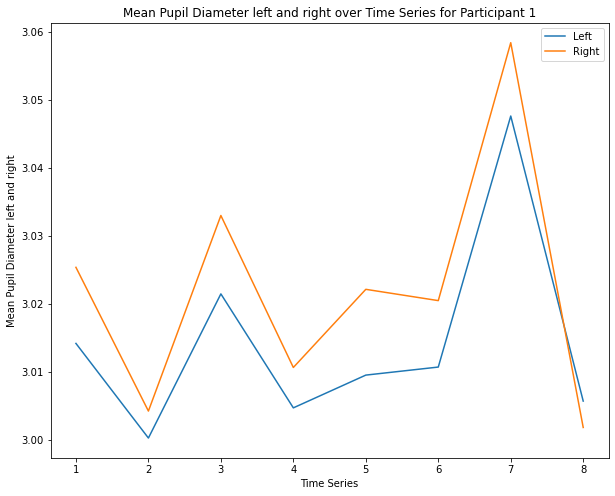

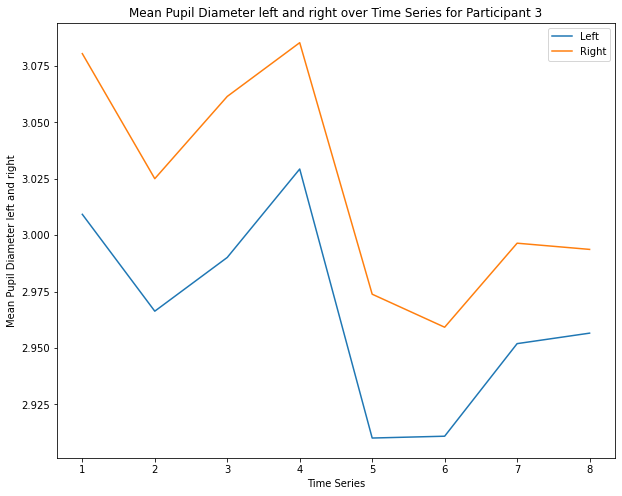

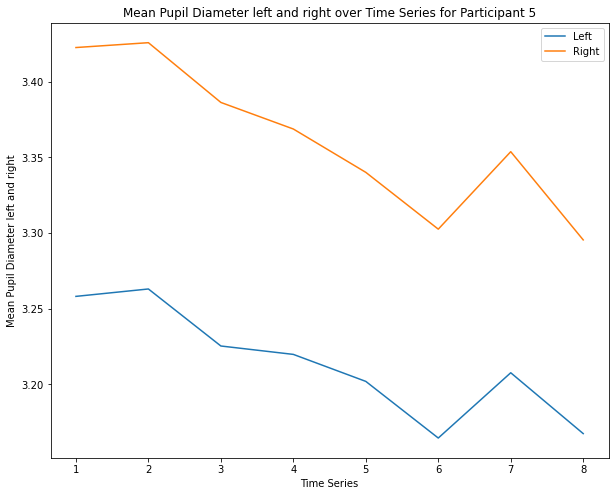

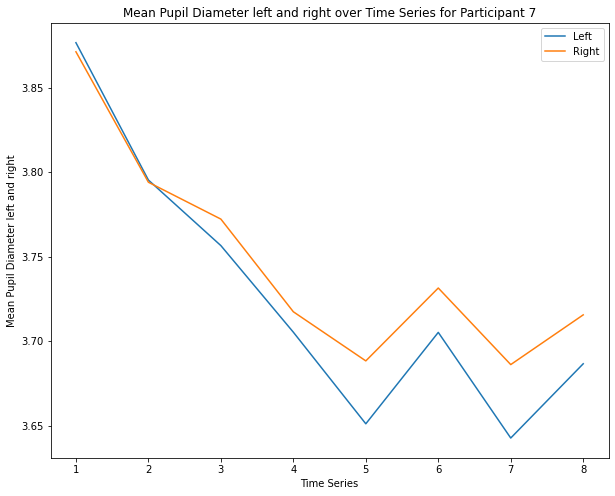

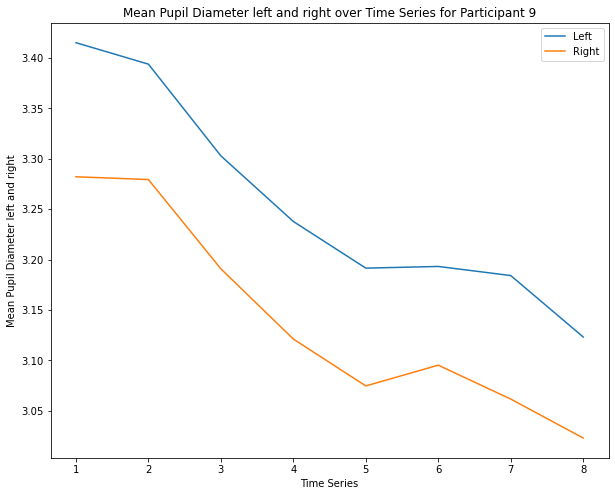

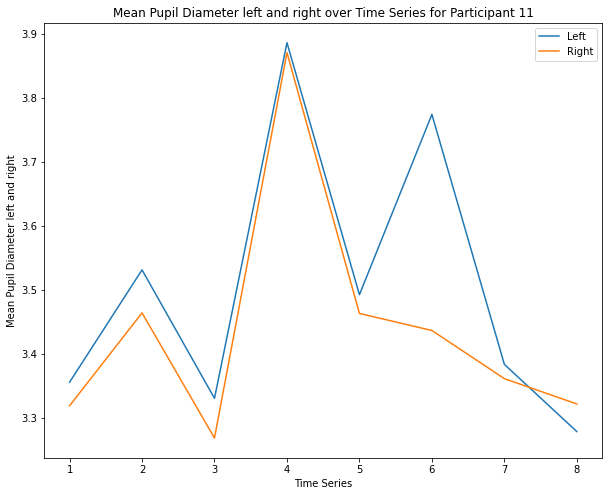

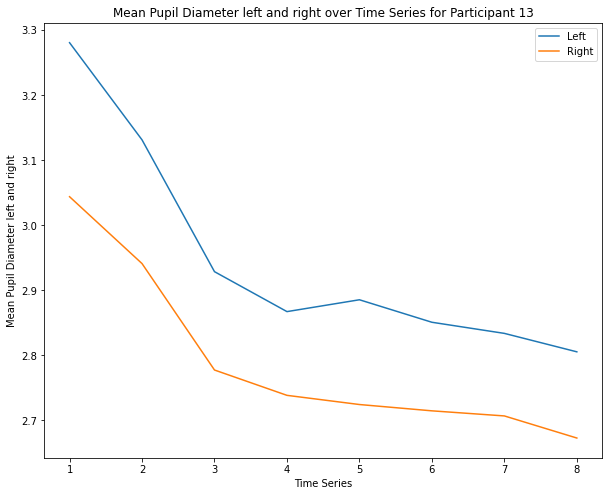

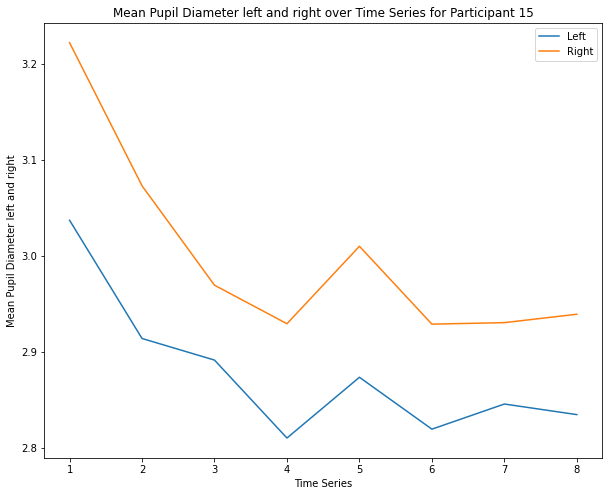

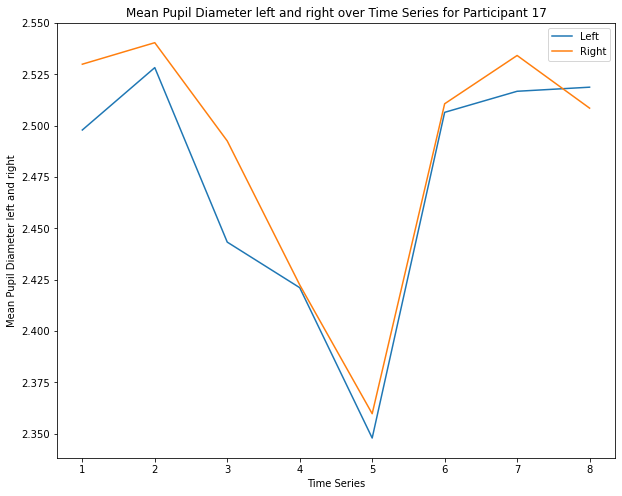

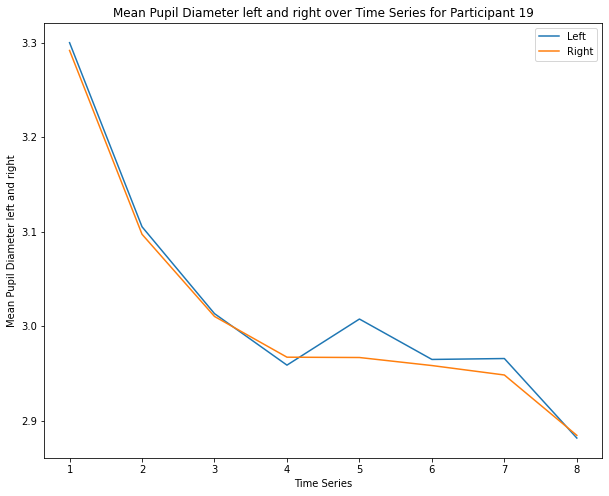

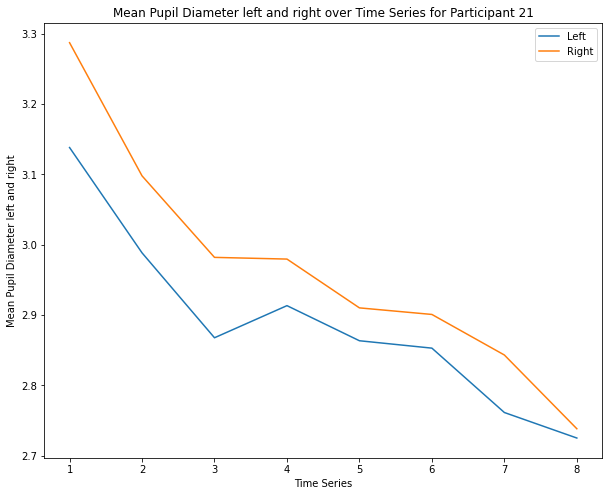

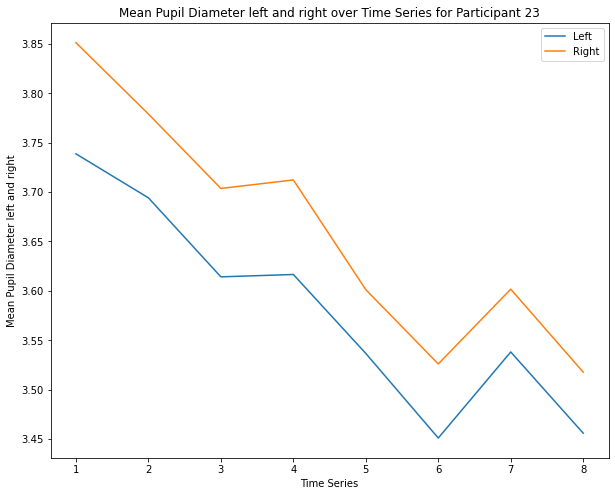

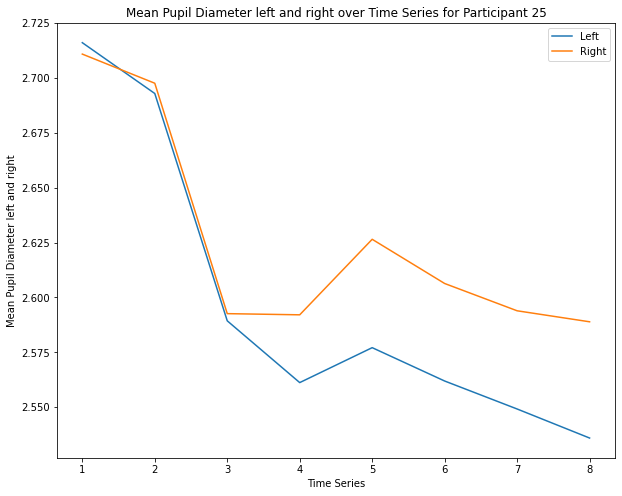

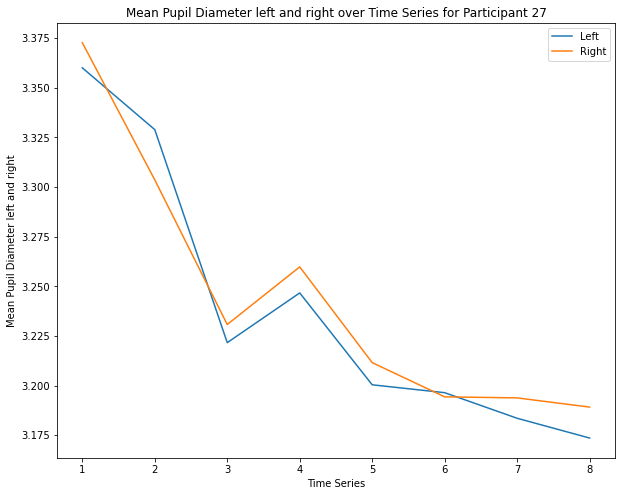

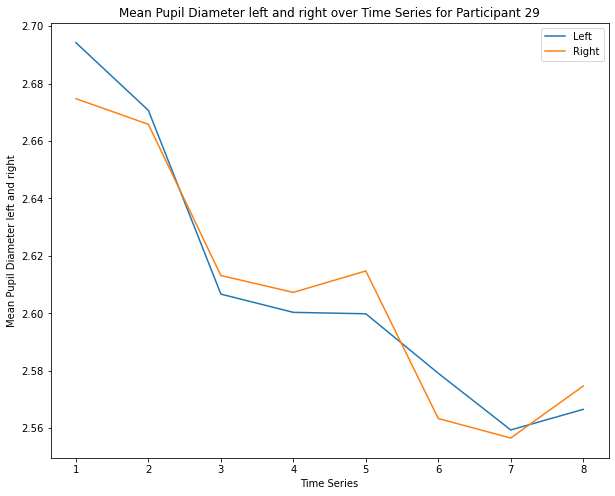

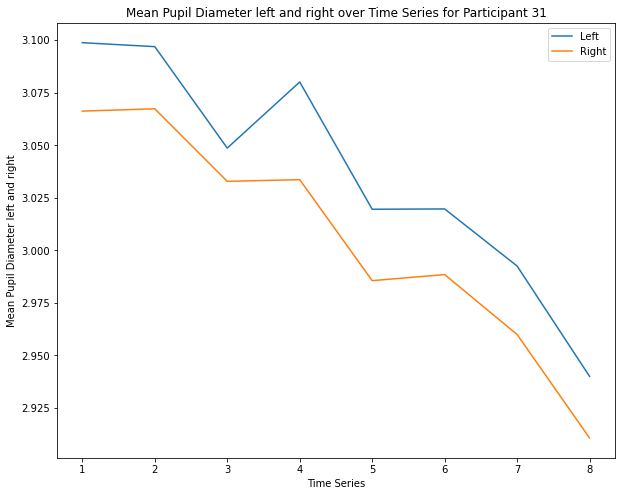

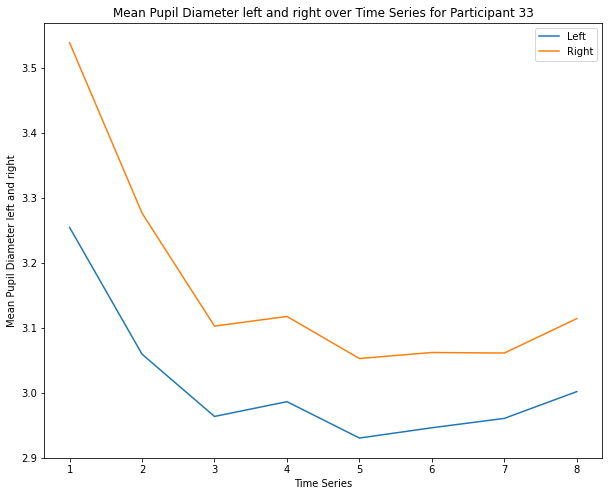

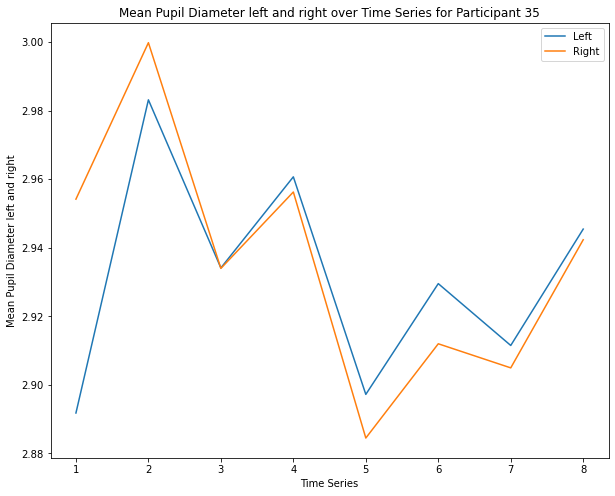

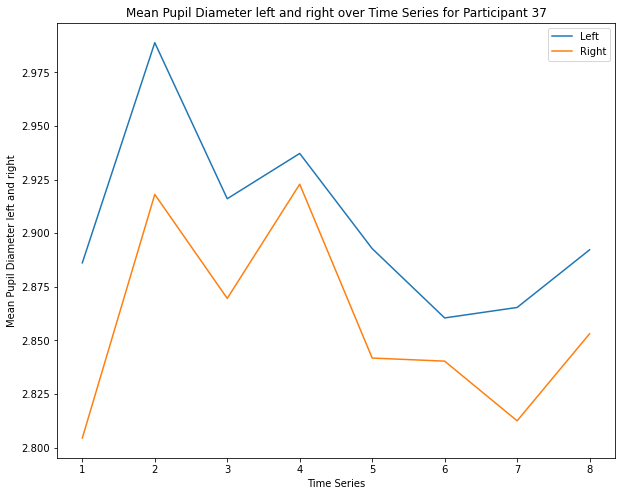

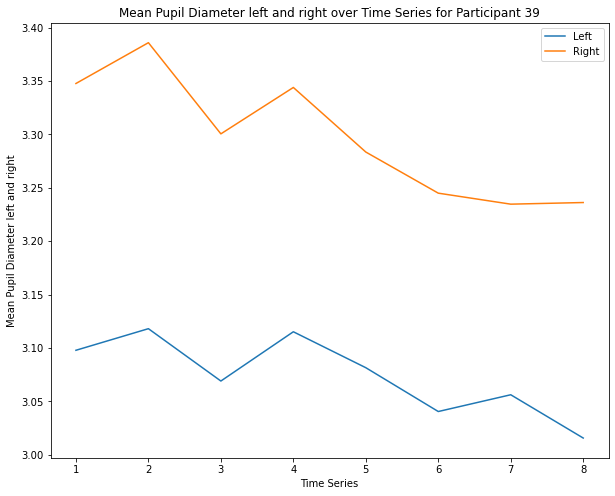

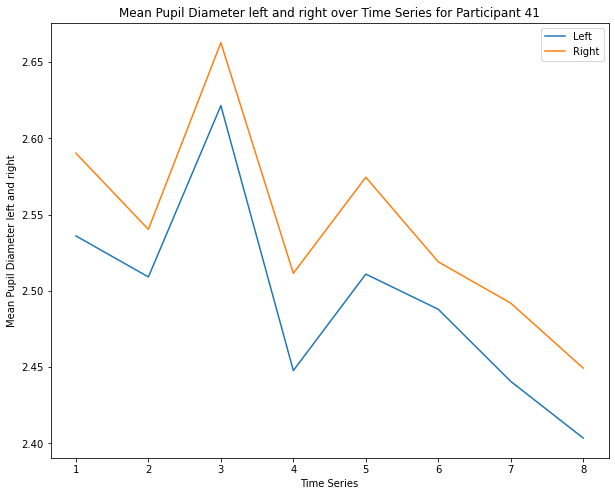

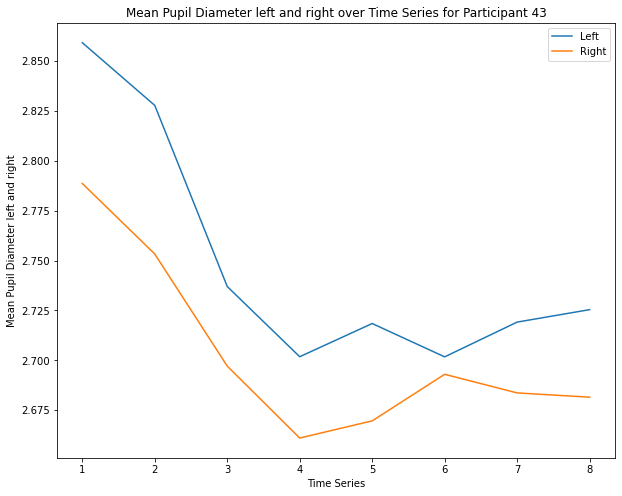

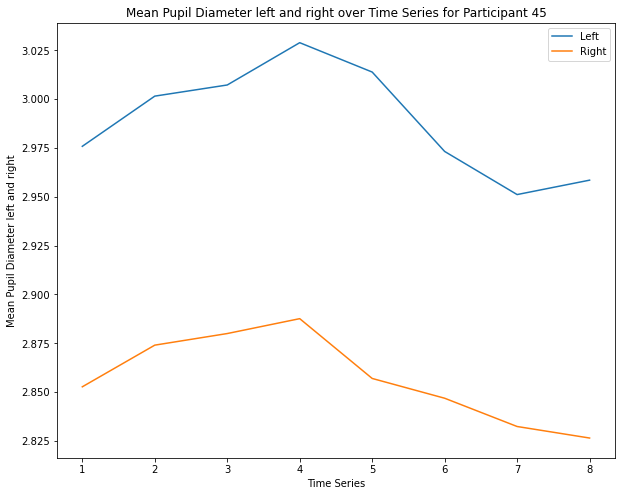

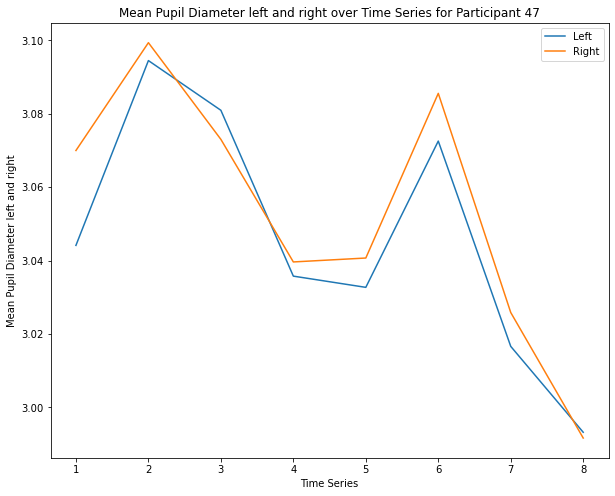

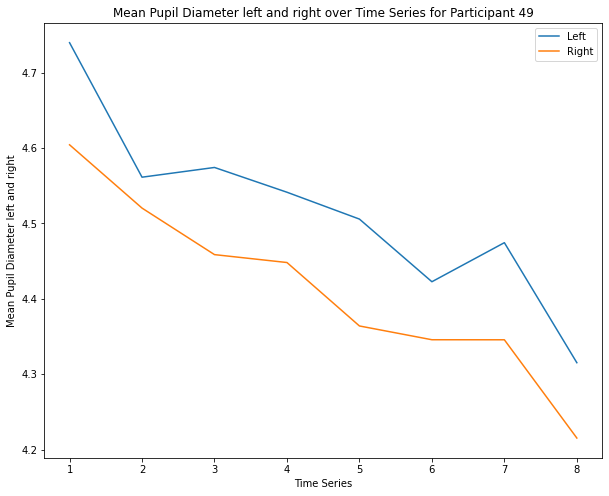

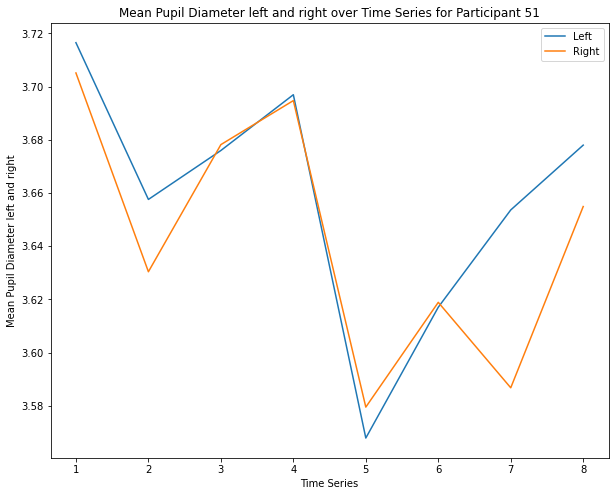

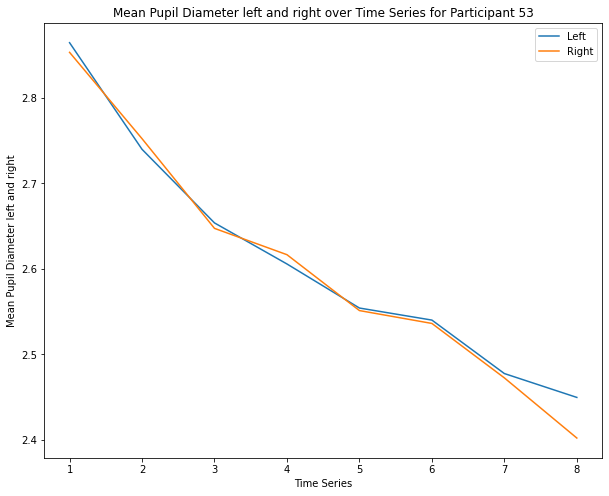

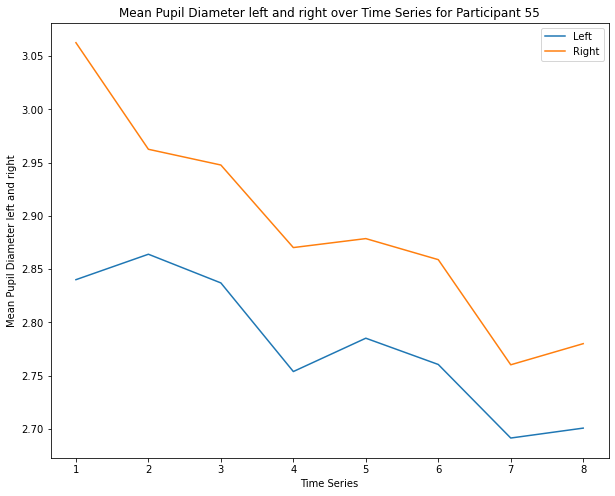

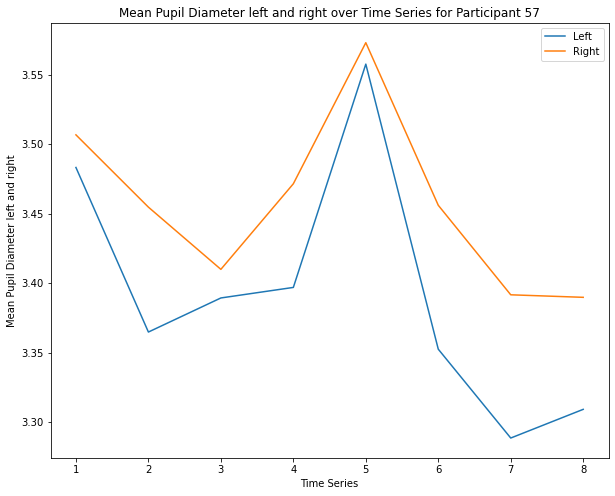

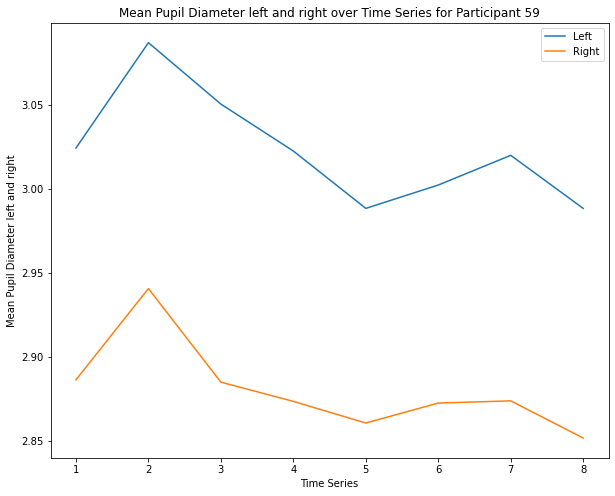

In [28]:
participants = results['Participant'].unique()


for participant_name in participants:
    fig, ax = plt.subplots(figsize=(10, 8))
    participant_data = results[results['Participant'] == participant_name]
    #ax.plot(participant_data['Time Series'], participant_data['Mean Pupil Diameter'])
    ax.plot(participant_data['Time Series'], participant_data['Mean Pupil Diameter left'], label='Left')
    ax.plot(participant_data['Time Series'], participant_data['Mean Pupil Diameter right'], label='Right')
    ax.set_xlabel('Time Series')
    ax.set_ylabel('Mean Pupil Diameter left and right')
    ax.set_title('Mean Pupil Diameter left and right over Time Series for Participant {}'.format(participant_name))
    ax.legend()
    plt.show()

### Extracting the emapthy score before and after the intervention

In [29]:

columns_A = ['Participant nr','Total Score original','Total Score extended']

empathy_before = pd.read_csv('Questionnaire_datasetIA.csv',encoding = 'ISO-8859-1',
                             usecols=columns_A, dtype={'Participant nr' : str})

empathy_after = pd.read_csv('Questionnaire_datasetIB.csv',encoding = 'ISO-8859-1',
                             usecols=columns_A, dtype={'Participant nr' : str})

### Merging the empathy scores with the eye tracking data

In [30]:
merged_before = pd.merge(results, empathy_before[['Participant nr', 'Total Score extended']], left_on='Participant',
                         right_on='Participant nr', how='left')


merged_before = merged_before.rename(columns={'Total Score extended': 'Total Score extended before'})

merged_before = merged_before.drop('Participant nr', axis=1)

merged_after = pd.merge(results, empathy_after[['Participant nr', 'Total Score extended']], left_on='Participant', right_on='Participant nr', how='left')


merged_after = merged_after.rename(columns={'Total Score extended': 'Total Score extended after'})


merged_after = merged_after.drop('Participant nr', axis=1)


merged_data  = pd.concat([merged_before, merged_after[['Total Score extended after']]], axis=1)


In [71]:
merged_data

,Participant,Time Series,Mean Pupil Diameter,Fixation Fraction,Saccade Fraction,Fixation Count,Saccade Count,Fixation Duration,Saccade Duration,Mean Pupil Diameter left,Mean Pupil Diameter right,Total Score extended before,Total Score extended after,Avg_Empathy_Score,Emapthy_Score_diff
0,1,1,3.019796,0.583092,0.260636,25410.0,11358.0,7393989.0,7370436.0,3.014209,3.025383,134,137,135.5,3
1,1,2,3.002296,0.619550,0.246598,26772.0,10656.0,7495499.0,7153857.0,3.000315,3.004276,134,137,135.5,3
2,1,3,3.027238,0.589332,0.241688,24462.0,10032.0,2354221.0,3737461.0,3.021483,3.032994,134,137,135.5,3
3,1,4,3.007712,0.622917,0.246151,23550.0,9306.0,7491415.0,7124715.0,3.004746,3.010678,134,137,135.5,3
4,1,5,3.015855,0.581654,0.260117,21990.0,9834.0,7408069.0,7449757.0,3.009557,3.022153,134,137,135.5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,59,4,2.947811,0.338324,0.125779,3096.0,1151.0,9228080.0,7967456.0,3.022330,2.873292,131,136,133.5,5
236,59,5,2.924299,0.354435,0.152561,3141.0,1352.0,9036399.0,9260175.0,2.988185,2.860413,131,136,133.5,5
237,59,6,2.937195,0.308828,0.127718,1903.0,787.0,622342.0,2623815.0,3.002083,2.872306,131,136,133.5,5
238,59,7,2.946682,0.358175,0.132135,2033.0,750.0,9228611.0,9228557.0,3.019765,2.873599,131,136,133.5,5


In [32]:
merged_data['Avg_Empathy_Score'] = (merged_data['Total Score extended before'] + merged_data['Total Score extended after'])/2
merged_data['Emapthy_Score_diff'] =   merged_data['Total Score extended after']  - merged_data['Total Score extended before']

In [33]:
merged_data

,Participant,Time Series,Mean Pupil Diameter,Fixation Fraction,Saccade Fraction,Fixation Count,Saccade Count,Fixation Duration,Saccade Duration,Mean Pupil Diameter left,Mean Pupil Diameter right,Total Score extended before,Total Score extended after,Avg_Empathy_Score,Emapthy_Score_diff
0,1,1,3.019796,0.583092,0.260636,25410,11358,7393989.0,7370436.0,3.014209,3.025383,134,137,135.5,3
1,1,2,3.002296,0.619550,0.246598,26772,10656,7495499.0,7153857.0,3.000315,3.004276,134,137,135.5,3
2,1,3,3.027238,0.589332,0.241688,24462,10032,2354221.0,3737461.0,3.021483,3.032994,134,137,135.5,3
3,1,4,3.007712,0.622917,0.246151,23550,9306,7491415.0,7124715.0,3.004746,3.010678,134,137,135.5,3
4,1,5,3.015855,0.581654,0.260117,21990,9834,7408069.0,7449757.0,3.009557,3.022153,134,137,135.5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,59,4,2.947811,0.338324,0.125779,3096,1151,9228080.0,7967456.0,3.022330,2.873292,131,136,133.5,5
236,59,5,2.924299,0.354435,0.152561,3141,1352,9036399.0,9260175.0,2.988185,2.860413,131,136,133.5,5
237,59,6,2.937195,0.308828,0.127718,1903,787,622342.0,2623815.0,3.002083,2.872306,131,136,133.5,5
238,59,7,2.946682,0.358175,0.132135,2033,750,9228611.0,9228557.0,3.019765,2.873599,131,136,133.5,5


###  Plot the changes in mean pupil diameter for all participants over time series

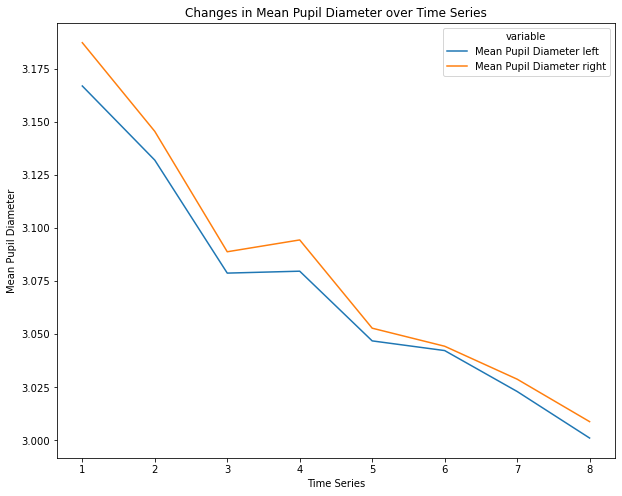

In [34]:
# Melt the data to create a long-form DataFrame
melted_data = pd.melt(merged_data, id_vars=['Participant', 'Time Series'], value_vars=['Mean Pupil Diameter left', 'Mean Pupil Diameter right'])


plt.figure(figsize = (10,8))
sns.lineplot(x='Time Series', y='value', hue='variable', data=melted_data, ci=None)

plt.title('Changes in Mean Pupil Diameter over Time Series')
plt.xlabel('Time Series')
plt.ylabel('Mean Pupil Diameter')
plt.show()

### Mean Pupil Diameter over time series for each participant

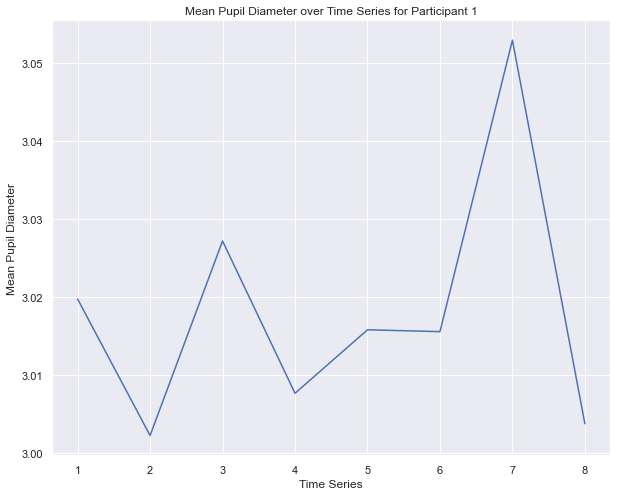

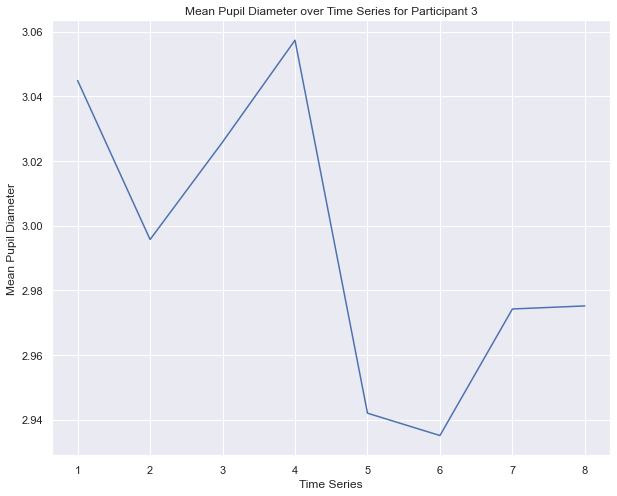

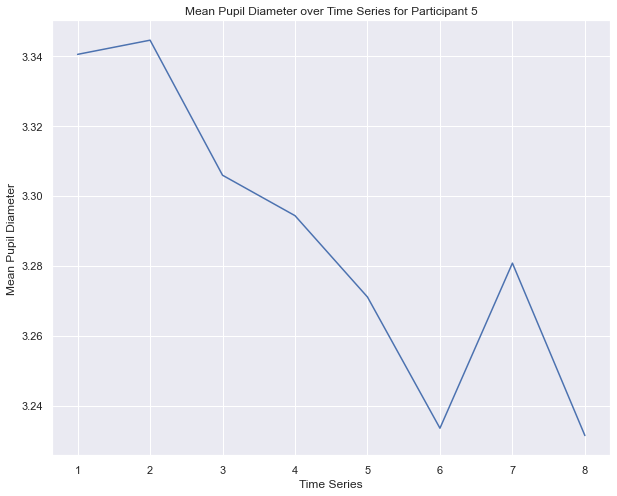

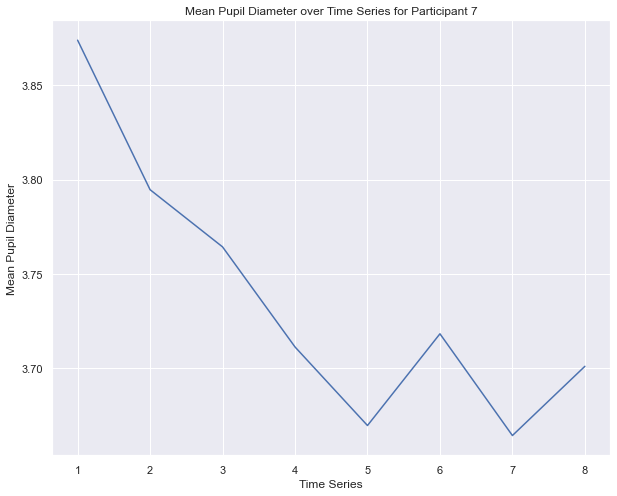

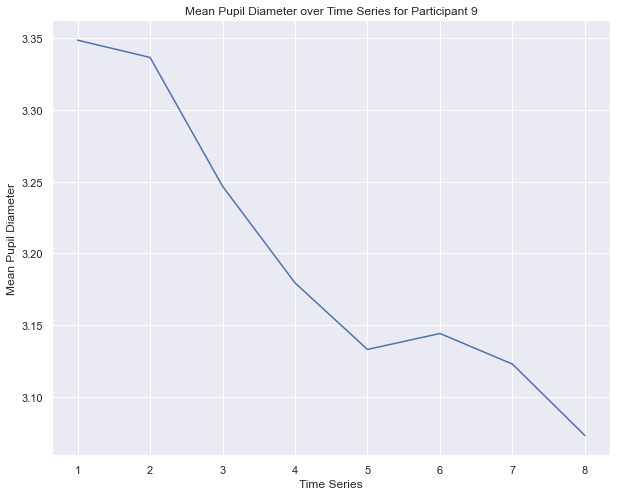

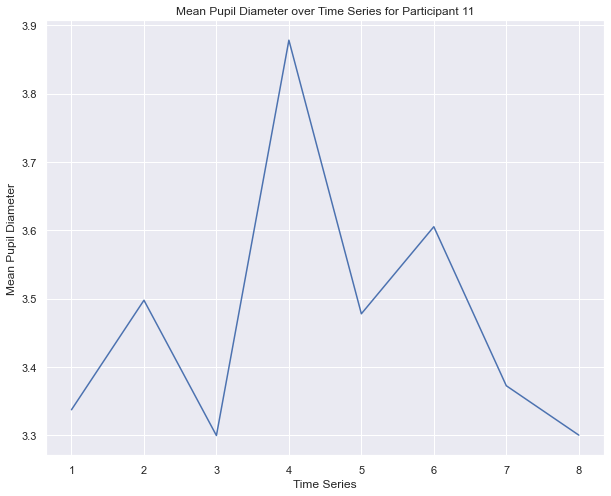

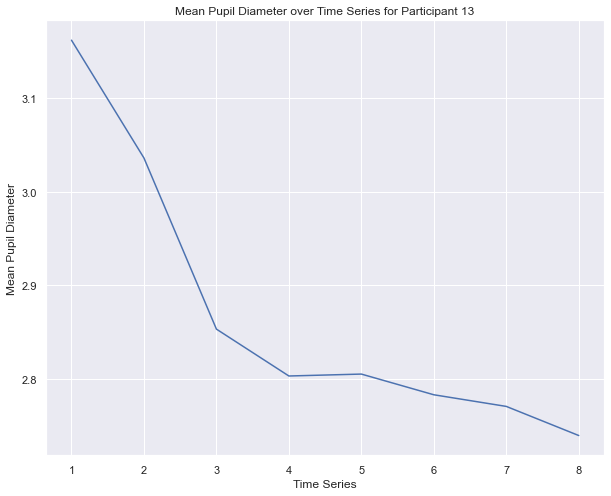

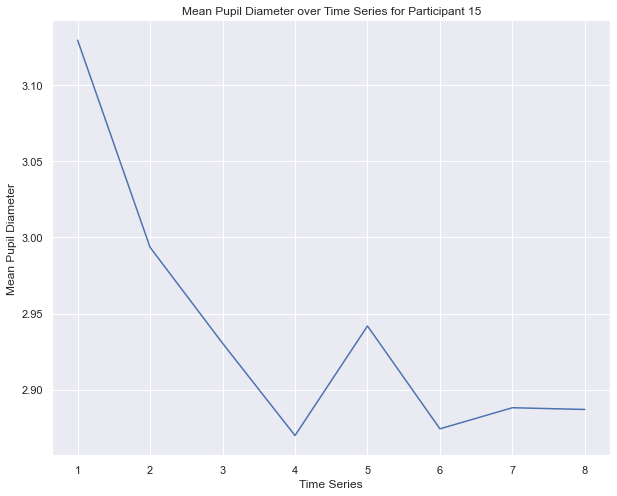

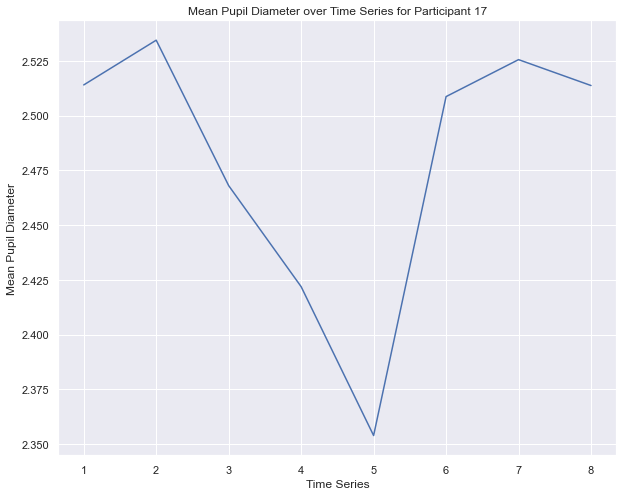

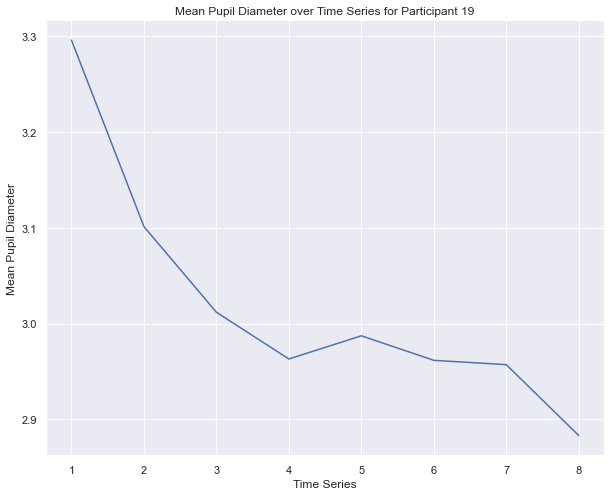

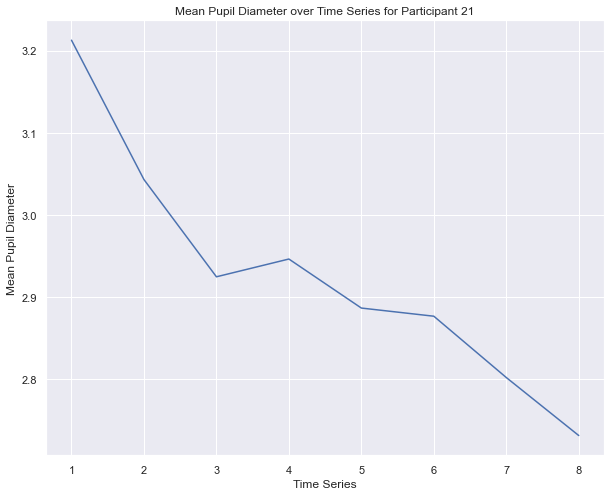

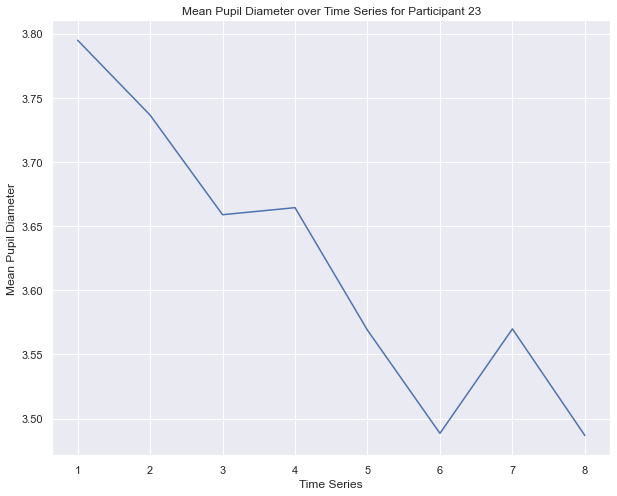

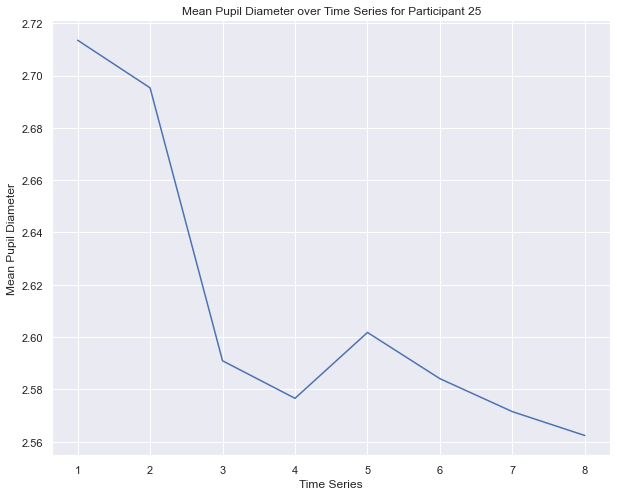

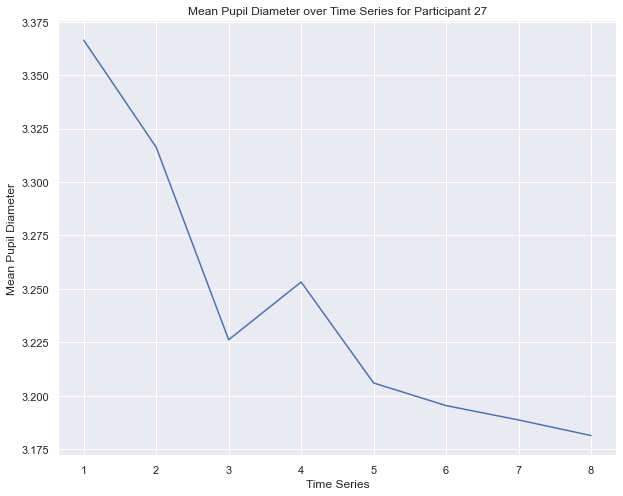

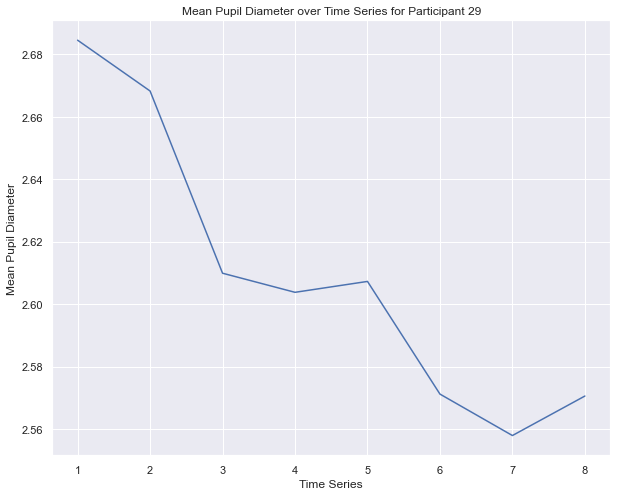

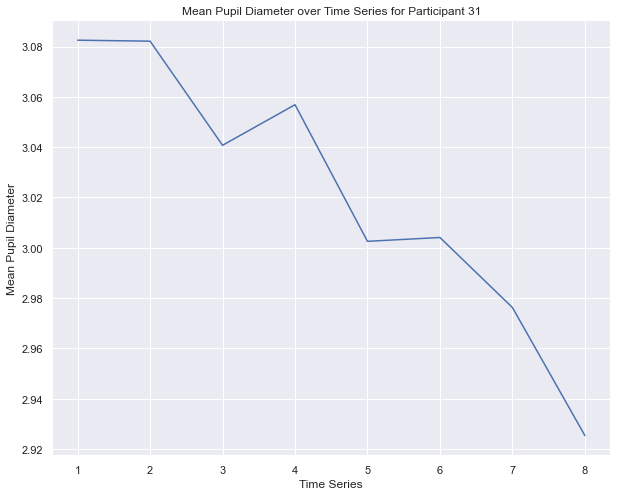

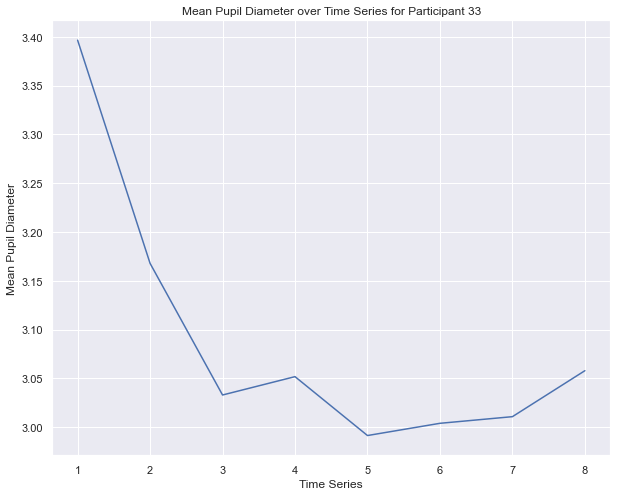

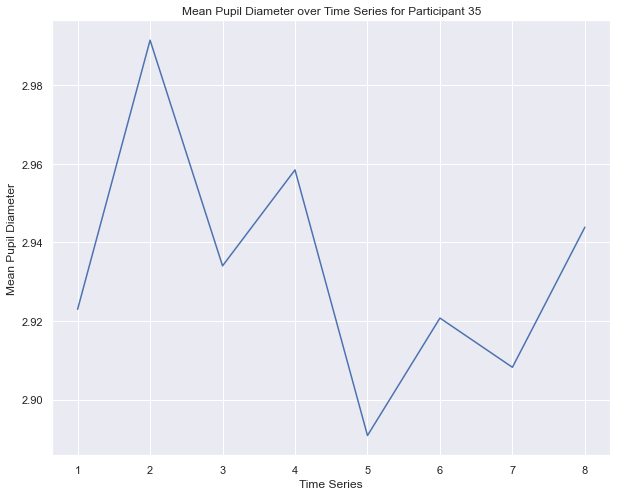

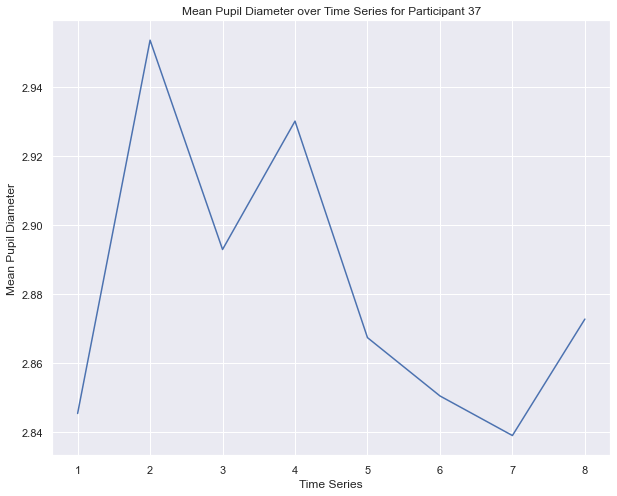

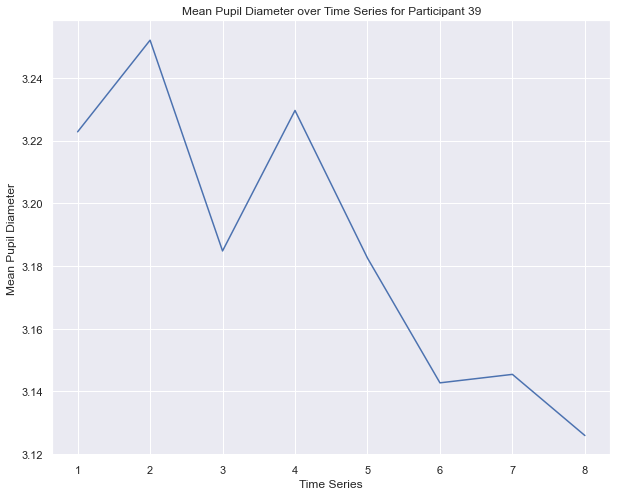

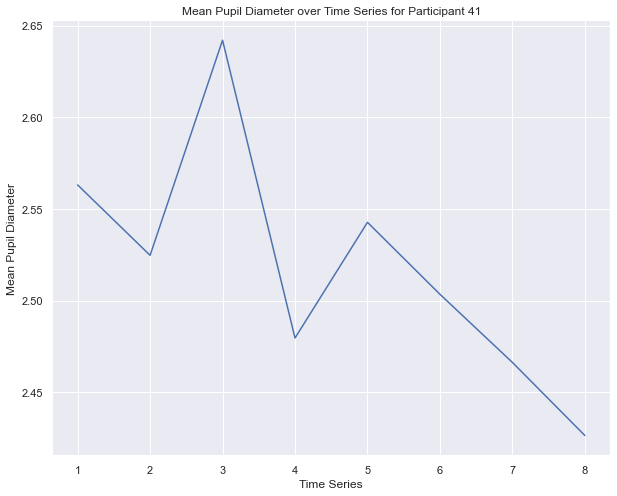

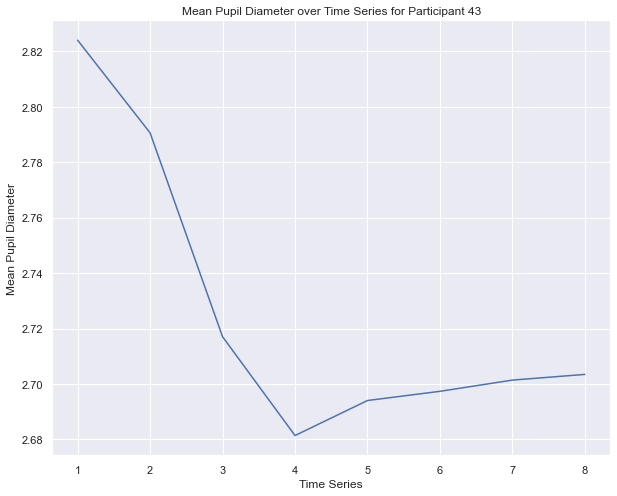

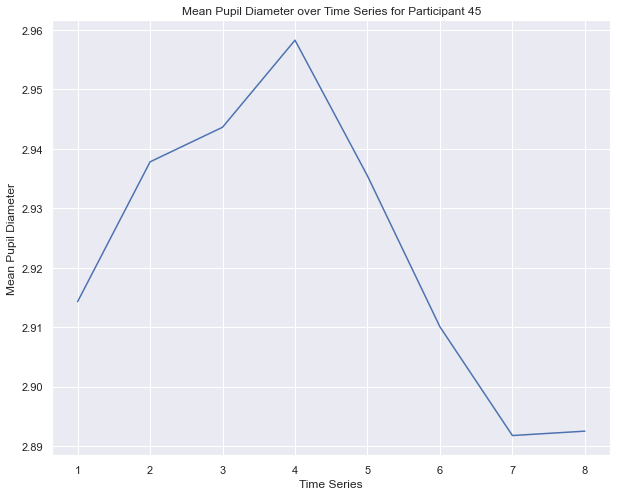

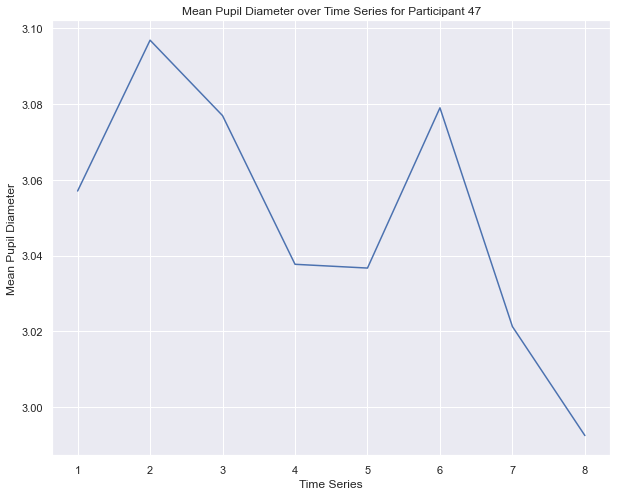

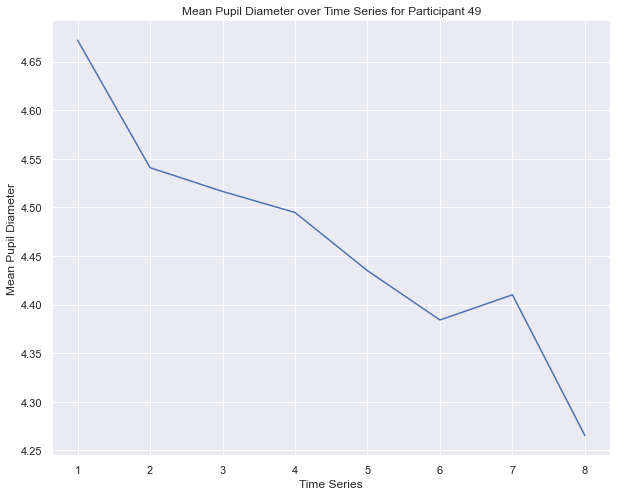

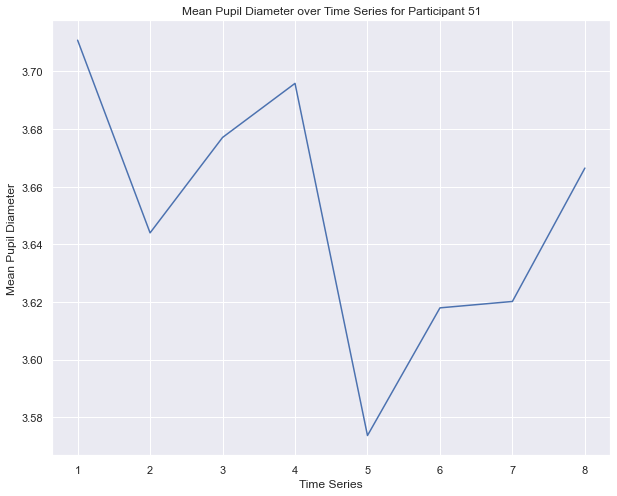

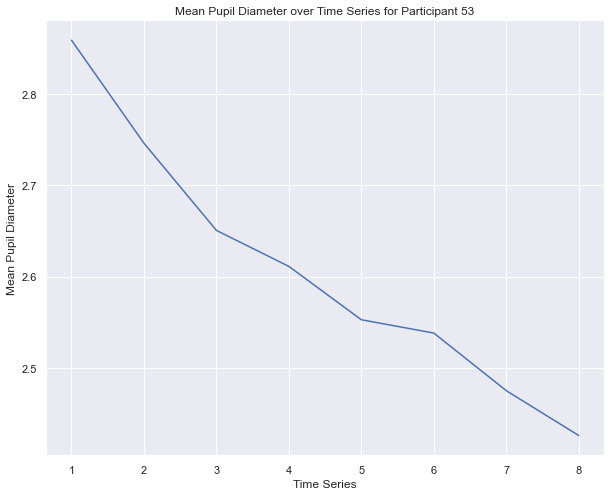

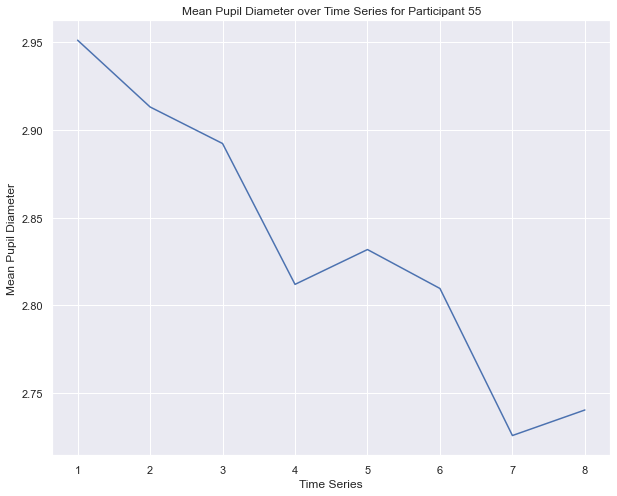

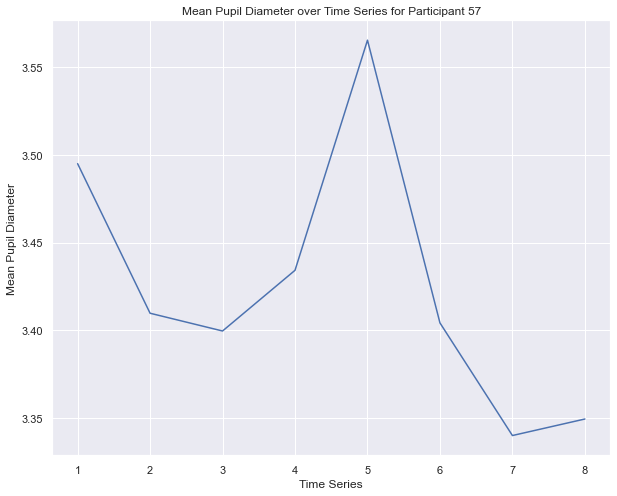

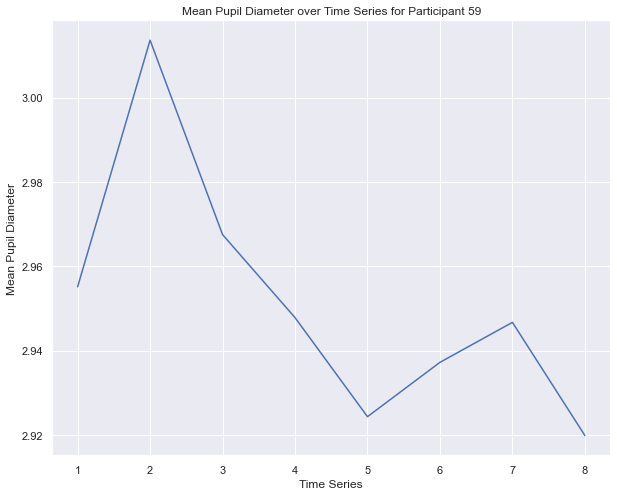

In [72]:
# Get a list of all participant names
participant_names = merged_data['Participant'].unique()


for participant_name in participant_names:
    fig, ax = plt.subplots(figsize=(10, 8))
    participant_data = merged_data[merged_data['Participant'] == participant_name]
    ax.plot(participant_data['Time Series'], participant_data['Mean Pupil Diameter'])
    ax.set_xlabel('Time Series')
    ax.set_ylabel('Mean Pupil Diameter')
    ax.set_title('Mean Pupil Diameter over Time Series for Participant {}'.format(participant_name))
    plt.show()

In [36]:
merged_data[['Fixation Count','Saccade Count']] = merged_data[['Fixation Count','Saccade Count']].astype(float)

In [73]:
merged_data.to_csv('Test_group.csv')

### Checking for the correlation between the features

In [74]:
# Calculating the correlation coefficients between the features
correlations2 = merged_data[['Mean Pupil Diameter', 'Total Score extended before', 
                            'Total Score extended after', 'Avg_Empathy_Score',
                            'Fixation Duration', 'Saccade Duration',
                            'Fixation Count', 'Saccade Count']].corr()

In [76]:
correlations2

,Mean Pupil Diameter,Total Score extended before,Total Score extended after,Avg_Empathy_Score,Fixation Duration,Saccade Duration,Fixation Count,Saccade Count
Mean Pupil Diameter,1.000000,0.013531,-0.143947,-0.084420,-0.008875,-0.046653,0.124366,0.066605
Total Score extended before,0.013531,1.000000,0.342197,0.798343,0.396863,0.414664,0.336962,0.187085
Total Score extended after,-0.143947,0.342197,1.000000,0.839038,0.302467,0.353158,0.061121,0.087834
Avg_Empathy_Score,-0.084420,0.798343,0.839038,1.000000,0.423645,0.466440,0.234283,0.164620
Fixation Duration,-0.008875,0.396863,0.302467,0.423645,1.000000,0.944255,0.396005,0.296768
Saccade Duration,-0.046653,0.414664,0.353158,0.466440,0.944255,1.000000,0.396603,0.326307
Fixation Count,0.124366,0.336962,0.061121,0.234283,0.396005,0.396603,1.000000,0.862569
Saccade Count,0.066605,0.187085,0.087834,0.164620,0.296768,0.326307,0.862569,1.000000


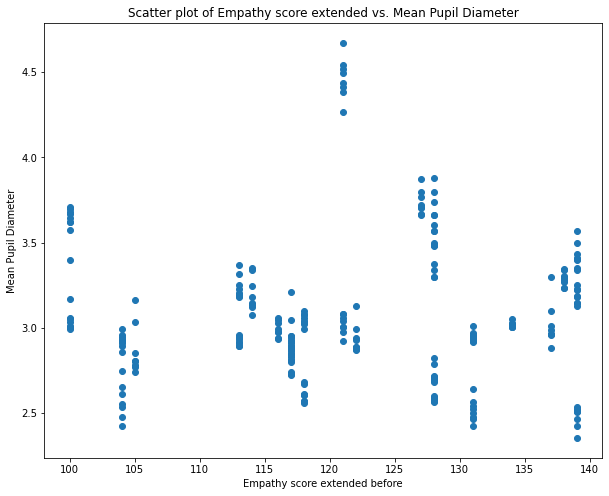

In [39]:
# Plotting Mean pupil diameter with extended empathy score before
plt.figure(figsize = (10,8))
plt.scatter(merged_data['Total Score extended before'], merged_data['Mean Pupil Diameter'])
plt.xlabel('Empathy score extended before')
plt.ylabel('Mean Pupil Diameter')
plt.title('Scatter plot of Empathy score extended vs. Mean Pupil Diameter')
plt.show()

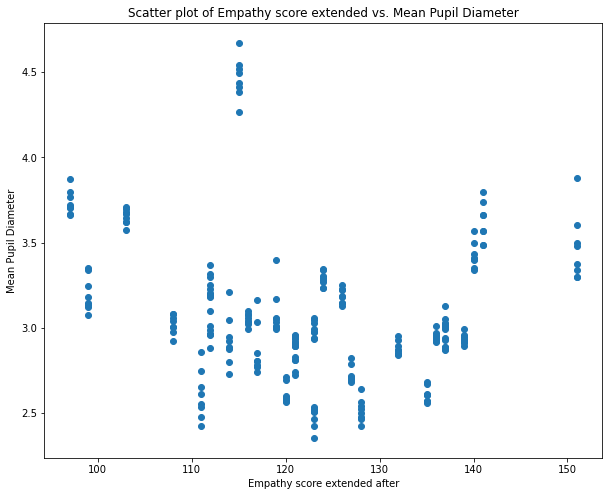

In [40]:
# Plotting Mean pupil diameter with extended empathy score after
plt.figure(figsize = (10,8))
plt.scatter(merged_data['Total Score extended after'], merged_data['Mean Pupil Diameter'])
plt.xlabel('Empathy score extended after')
plt.ylabel('Mean Pupil Diameter')
plt.title('Scatter plot of Empathy score extended vs. Mean Pupil Diameter')
plt.show()

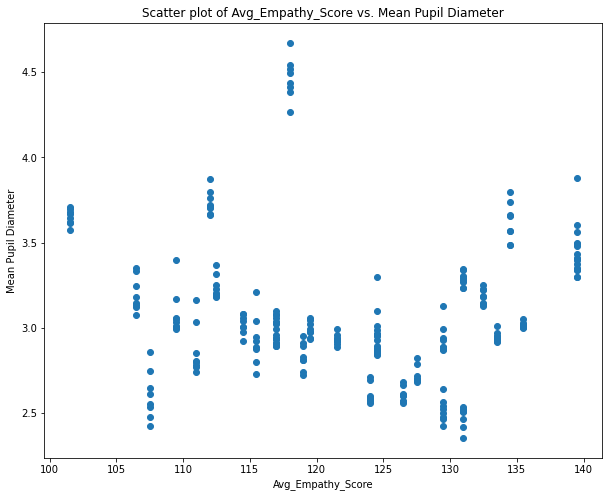

In [41]:
plt.figure(figsize = (10,8))
plt.scatter(merged_data['Avg_Empathy_Score'], merged_data['Mean Pupil Diameter'])
plt.xlabel('Avg_Empathy_Score')
plt.ylabel('Mean Pupil Diameter')
plt.title('Scatter plot of Avg_Empathy_Score vs. Mean Pupil Diameter')
plt.show()

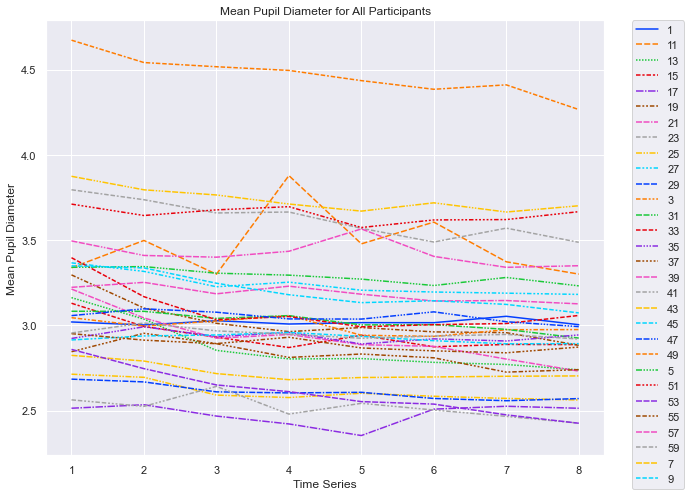

In [42]:
#Plotting mean pupil diameter vs time series for all participants 
plt.figure(figsize =(10,8))
pivoted_data = results.pivot(index='Participant', columns='Time Series', values='Mean Pupil Diameter')

# Create a line plot of the mean pupil diameter for each participant
sns.set(style="darkgrid")
sns.lineplot(data=pivoted_data.T, palette='bright')

# Add axis labels and a title
plt.xlabel('Time Series')
plt.ylabel('Mean Pupil Diameter')
plt.title('Mean Pupil Diameter for All Participants')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

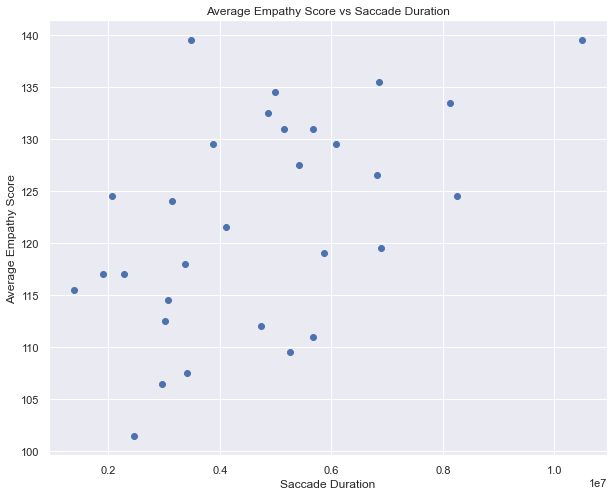

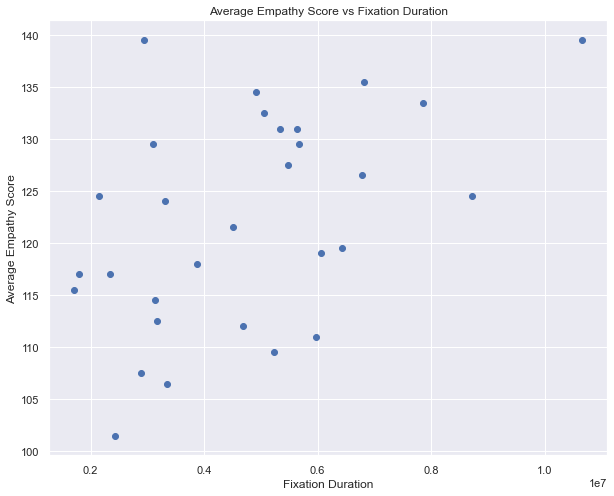

In [43]:
import matplotlib.pyplot as plt

grouped_data = merged_data.groupby('Participant').agg({'Avg_Empathy_Score': 'mean', 'Fixation Duration': 'mean', 'Saccade Duration': 'mean'})

# Creating a scatter plot of Saccade Duration and Avg_Empathy_Score
plt.figure(figsize = (10,8))
plt.scatter(grouped_data['Saccade Duration'], grouped_data['Avg_Empathy_Score'])
plt.xlabel('Saccade Duration')
plt.ylabel('Average Empathy Score')
plt.title('Average Empathy Score vs Saccade Duration')
plt.show()

# Creating a scatter plot of Fixation Duration and Avg_Empathy_Score
plt.figure(figsize = (10,8))
plt.scatter(grouped_data['Fixation Duration'], grouped_data['Avg_Empathy_Score'])
plt.xlabel('Fixation Duration')
plt.ylabel('Average Empathy Score')
plt.title('Average Empathy Score vs Fixation Duration')
plt.show()

In [61]:
ml = merged_data[['Participant','Mean Pupil Diameter','Fixation Count','Saccade Count',
                  'Avg_Empathy_Score']]

In [62]:
ml

,Participant,Mean Pupil Diameter,Fixation Count,Saccade Count,Avg_Empathy_Score
0,1,3.019796,25410.0,11358.0,135.5
1,1,3.002296,26772.0,10656.0,135.5
2,1,3.027238,24462.0,10032.0,135.5
3,1,3.007712,23550.0,9306.0,135.5
4,1,3.015855,21990.0,9834.0,135.5
...,...,...,...,...,...
235,59,2.947811,3096.0,1151.0,133.5
236,59,2.924299,3141.0,1352.0,133.5
237,59,2.937195,1903.0,787.0,133.5
238,59,2.946682,2033.0,750.0,133.5


### Implementing Machine learning pipeline to predict the empathy score


In [82]:

# Splitting the data into features varibale X and target variable y
X = ml[['Mean Pupil Diameter','Fixation Count','Saccade Count']]
y = ml['Avg_Empathy_Score']

# Initialize the linear regression and random forest regression models
lr = LinearRegression()
rf = RandomForestRegressor()

# Initializing the pipeline for the linear regression model
lr_pipeline = Pipeline(steps=[('linear_reg', lr)])

# Initializing  the pipeline for the random forest regression model
rf_pipeline = Pipeline(steps=[('random_forest', rf)])

# Initialize a list to store the RMSE for each fold
rmse_list_lr = []
rmse_list_rf = []

# Initialize a list to store the RMSE for each fold
r2_list_lr = []
r2_list_rf = []


# Perform 10-fold cross-validation for linear regression
g = GroupKFold(n_splits=10)
for train_idx, test_idx in g.split(X, y, groups=ml['Participant']):
    # Split the data into training and testing sets for each fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Fit the linear regression model to the training data
    lr_pipeline.fit(X_train, y_train)
    
    # Make predictions for the test data
    y_pred = lr_pipeline.predict(X_test)
    
    
    #Calculate the r2 for the model prediction
    r2 = r2_score(y_test, y_pred)
    r2_list_lr.append(r2)
    
    # Calculate the RMSE for the model predictions
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Add the RMSE to the list
    rmse_list_lr.append(rmse)

# Perform 10-fold cross-validation for random forest regression
for train_idx, test_idx in g.split(X, y, groups=ml['Participant']):
    # Split the data into training and testing sets for each fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Fit the random forest regression model to the training data
    rf_pipeline.fit(X_train, y_train)
    
    # Make predictions for the test data
    y_pred = rf_pipeline.predict(X_test)
    
    #Calculate the r2 for the model prediction
    r2 = r2_score(y_test, y_pred)
    r2_list_rf.append(r2)
    
    
    # Calculate the RMSE for the model's predictions
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Add the RMSE to the list
    rmse_list_rf.append(rmse)

# Calculating the mean RMSE across all folds for linear regression
mean_rmse_lr = np.mean(rmse_list_lr)
print('Mean RMSE for Linear Regression:', mean_rmse_lr)

# Calculating the r2 scores across all folds for linear regression
mean_r2_lr = np.mean(r2_list_lr)
print('Mean r2 for Linear Regression:', mean_r2_lr)
#####################################################################################3

# Calculating the mean RMSE across all folds for random forest regression
mean_rmse_rf = np.mean(rmse_list_rf)
print('Mean RMSE for Random Forest Regression:', mean_rmse_rf)

# Calculating the  mean r2 scores across all folds for random forest regression
mean_r2_rf = np.mean(r2_list_rf)
print('Mean r2 for Linear Regression:', mean_r2_rf)

Mean RMSE for Linear Regression: 10.425433116491002
Mean r2 for Linear Regression: -4.802194414915562
Mean RMSE for Random Forest Regression: 13.980987522011457
Mean r2 for Linear Regression: -6.893521835764496


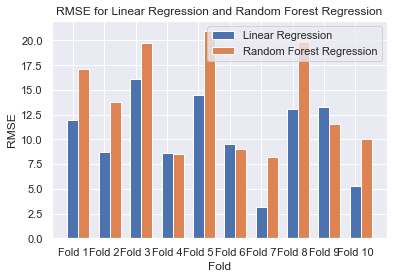

In [79]:
x_labels = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5','Fold 6','Fold 7','Fold 8','Fold 9','Fold 10']


bar_width = 0.35

fig, ax = plt.subplots()


ax.bar(x_labels, rmse_list_lr, bar_width, label='Linear Regression')
ax.bar([i + bar_width for i in range(len(rmse_list_rf))], rmse_list_rf, bar_width, label='Random Forest Regression')

ax.set_title('RMSE for Linear Regression and Random Forest Regression')
ax.set_xlabel('Fold')
ax.set_ylabel('RMSE')

ax.legend()

plt.show()

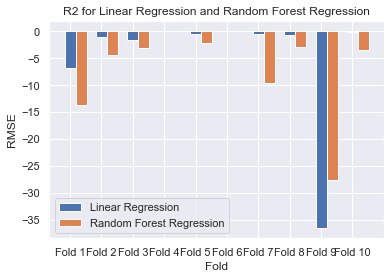

In [88]:
x_labels = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5','Fold 6','Fold 7','Fold 8','Fold 9','Fold 10']


bar_width = 0.35

fig, ax = plt.subplots()


ax.bar(x_labels, r2_list_lr, bar_width, label='Linear Regression')
ax.bar([i + bar_width for i in range(len(r2_list_rf))], r2_list_rf, bar_width, label='Random Forest Regression')

ax.set_title('R2 for Linear Regression and Random Forest Regression')
ax.set_xlabel('Fold')
ax.set_ylabel('RMSE')

ax.legend()

plt.show()